# Introduction

**Objective**<br>
* create clustering models to determine customer segmentation based on RFM features

**About dataset**
* This dataset is obtained from [Retail Transaction Data | Kaggle](https://www.kaggle.com/regivm/retailtransactiondata)

**Main Instructions**
* Describe the pre-processing step, how to extract and create new features, also the reason behind them
* Split the data into training and testing with optional portion
* Build the clustering models

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
%matplotlib inline

sns.set(rc={'figure.figsize':(16,8)})
sns.set_style("white")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

# Load and Describe Data

## Load Dataset 

In [2]:
df = pd.read_csv('Retail_Data_Transactions.csv')
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [3]:
print('There are', str(len(df)), 'rows in this dataset')

There are 125000 rows in this dataset


## Data Description

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  125000 non-null  object
 1   trans_date   125000 non-null  object
 2   tran_amount  125000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


**Conclusion**</br>
* Dataframe have 3 columns
* Dataframe have 125000 rows
* Total categorical columns are 2 columns
* Total numerical columns are 1 columns

## Check Null and Missing Values

In [5]:
# see the number of missing values from the data frame
data_missing_value = df.isnull().sum().reset_index()
data_missing_value.columns = ['feature','missing_value']
data_missing_value

,feature,missing_value
0,customer_id,0
1,trans_date,0
2,tran_amount,0


**There are no duplicate data in this dataset**

## Numerical Data

In [6]:
# assign the numerical data into nums object
numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
display(df.select_dtypes(include=numerics).columns)
print(df.select_dtypes(include=numerics).shape)
data_num = df.select_dtypes(include=numerics)
data_num.head(3)

Index(['tran_amount'], dtype='object')

(125000, 1)


,tran_amount
0,35
1,39
2,52


## Non Numerical Data

In [7]:
# assign the categorical data into cats object
display(df.select_dtypes(include=['object']).columns)
print(df.select_dtypes(include=object).shape)
data_cat = df.select_dtypes(include=['object'])
data_cat.head(3)

Index(['customer_id', 'trans_date'], dtype='object')

(125000, 2)


,customer_id,trans_date
0,CS5295,11-Feb-13
1,CS4768,15-Mar-15
2,CS2122,26-Feb-13


**Features which are numeric and non-numeric data are separated into two different objects.</br>
the `tran_amount` feature is numeric data</br>Change the date data type in the `tran_date` feature to be an integer based date data type
the `customer_id` and` tran_date` features are non-numeric data**

# Data Pre-Processing

## Convert `trans_date` column to date data type

**Change the date data type in the `tran_date` feature to be an integer based date data type**

In [8]:
#convert string to date type
df['trans_date'] = pd.to_datetime(df['trans_date'])

In [9]:
df['trans_date'] = df['trans_date'].dt.strftime('%Y-%m-%d')

In [10]:
df['trans_date'] = df['trans_date'].astype('datetime64[ns]')

In [11]:
#first and last date available in our dataset
print(df['trans_date'].min(), df['trans_date'].max())

2011-05-16 00:00:00 2015-03-16 00:00:00


**The maximum data of the last transaction is taken as a reference for calculating the recency value.</br>
The maximum data is then added by one day so that there are no blank values.**

In [12]:
#use latest date in our data as current date
import datetime as dt
now = dt.datetime(2015,3,17)
df['hist']=now - df['trans_date']
df['hist'].astype('timedelta64[D]')
df['hist']=df['hist'] / np.timedelta64(1, 'D')
df.head()

,customer_id,trans_date,tran_amount,hist
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [13]:
df.head()

,customer_id,trans_date,tran_amount,hist
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


## Make recency, frequency, and monetary column from `customer_id` groupby

In [14]:
#groupby `customer_id` and aggregate the three features to become new features.
rfm_table = df.groupby('customer_id').agg({'hist': lambda x:x.min(),# Recency
                                        'customer_id': lambda x: len(x),# Frequency
                                        'tran_amount': lambda x: x.sum()})# Monetary Value

In [15]:
#change the column name to `recency`,` frequency`, and `monetary`
rfm_table.rename(columns={'hist': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary'}, inplace=True)

In [16]:
rfm_table.head()

,recency,frequency,monetary
customer_id,,,
CS1112,62.0,15,1012
CS1113,36.0,20,1490
CS1114,33.0,19,1432
CS1115,12.0,22,1659
CS1116,204.0,13,857


In [17]:
#check the value from one of the customer data
df[df['customer_id']=='CS1112']

,customer_id,trans_date,tran_amount,hist
5650,CS1112,2015-01-14,39,62.0
17810,CS1112,2014-07-16,90,244.0
26626,CS1112,2014-04-29,63,322.0
31500,CS1112,2014-12-04,59,103.0
36486,CS1112,2012-04-08,56,1073.0
40368,CS1112,2012-12-15,76,822.0
42084,CS1112,2013-07-01,36,624.0
67735,CS1112,2012-07-03,81,987.0
68206,CS1112,2011-10-02,60,1262.0
74842,CS1112,2013-11-13,71,489.0


After comparison, the `recency`, `frequency`, and `monetary` values of rfm_table and df were appropriate

# Features Standardization

In [18]:
rfm_table.describe()

,recency,frequency,monetary
count,6889.000000,6889.000000,6889.000000
mean,81.538249,18.144869,1179.269705
std,85.382526,5.193014,465.832609
min,1.000000,4.000000,149.000000
25%,23.000000,14.000000,781.000000
50%,54.000000,18.000000,1227.000000
75%,112.000000,22.000000,1520.000000
max,858.000000,39.000000,2933.000000


In [19]:
#create a new data frame from the dataframe `rfm_table`
rfm_segmentation = rfm_table.copy()

In [20]:
feats = ['recency','frequency','monetary']
X = rfm_segmentation[feats].values

from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
new_df = pd.DataFrame(data = X_std, columns = feats)
new_df.describe()

,recency,frequency,monetary
count,6.889000e+03,6.889000e+03,6.889000e+03
mean,-8.966876e-17,1.139586e-15,5.726939e-16
std,1.000073e+00,1.000073e+00,1.000073e+00
min,-9.433323e-01,-2.724024e+00,-2.211834e+00
25%,-6.856496e-01,-7.982203e-01,-8.550252e-01
50%,-3.225513e-01,-2.789885e-02,1.024698e-01
75%,3.567939e-01,7.424226e-01,7.314967e-01
max,9.094579e+00,4.016289e+00,3.764995e+00


**standardization is done so that the distance of each feature is the same and makes machine learning fair and not in favor of one feature.**

# Modeling

## K-Means Clustering

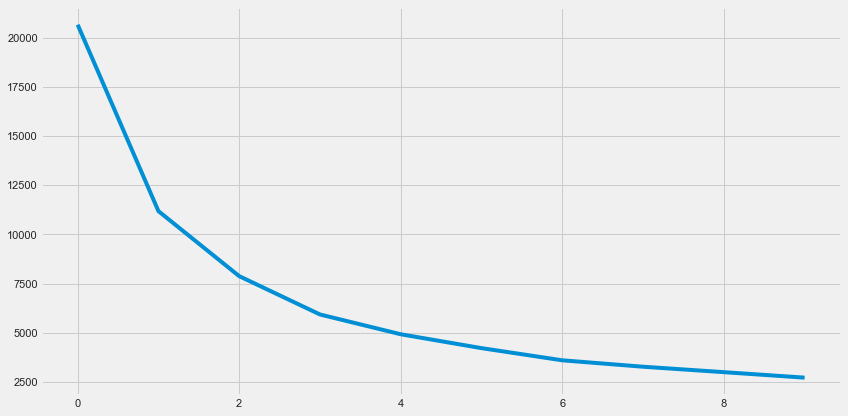

In [21]:
#K-Means Internal Evaluation: Elbow Method
from sklearn.cluster import KMeans
inertia = []

for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
  kmeans.fit(new_df.values)
  inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(inertia)
plt.tight_layout()
plt.savefig('fig/elbow.png', tight_box=True)

**Based on the results of the elbow method, to obtain the optimal number of clusters, a point is chosen after the inertia begins to decline linearly.</br>
So that the optimal number of clusters for the model to be carried out is three clusters.**

In [22]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(new_df.values)

KMeans(n_clusters=3, random_state=0)

In [23]:
#make new column `fit` with cluster values
new_df['cluster'] = kmeans.labels_

**The cluster results from K-Means Clustering are put into the `cluster` column**

In [24]:
#check our hypothesis
new_df[new_df.cluster == 0].head()

,recency,frequency,monetary,cluster
4,1.434376,-0.990801,-0.691865,0
5,2.066870,-0.220479,0.012302,0
14,1.153268,0.164682,-0.030635,0
23,2.980472,0.357262,0.188344,0
31,1.539792,-0.413060,0.162582,0


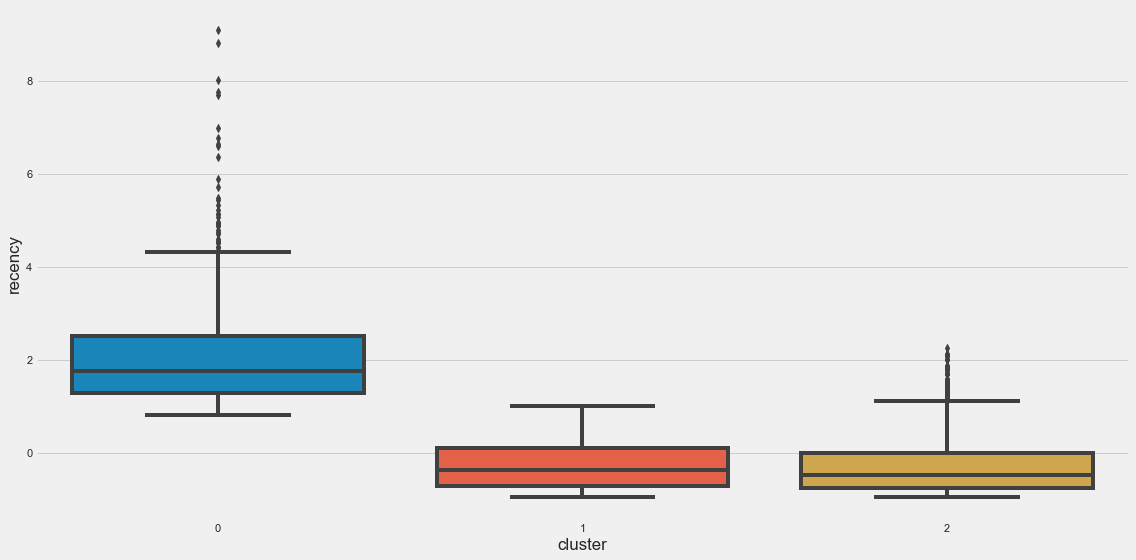

In [25]:
#see the distribution of recency feature based on cluster
sns.boxplot(new_df.cluster,new_df.recency)
plt.tight_layout()
plt.savefig('fig/recency.png', tight_box=True)

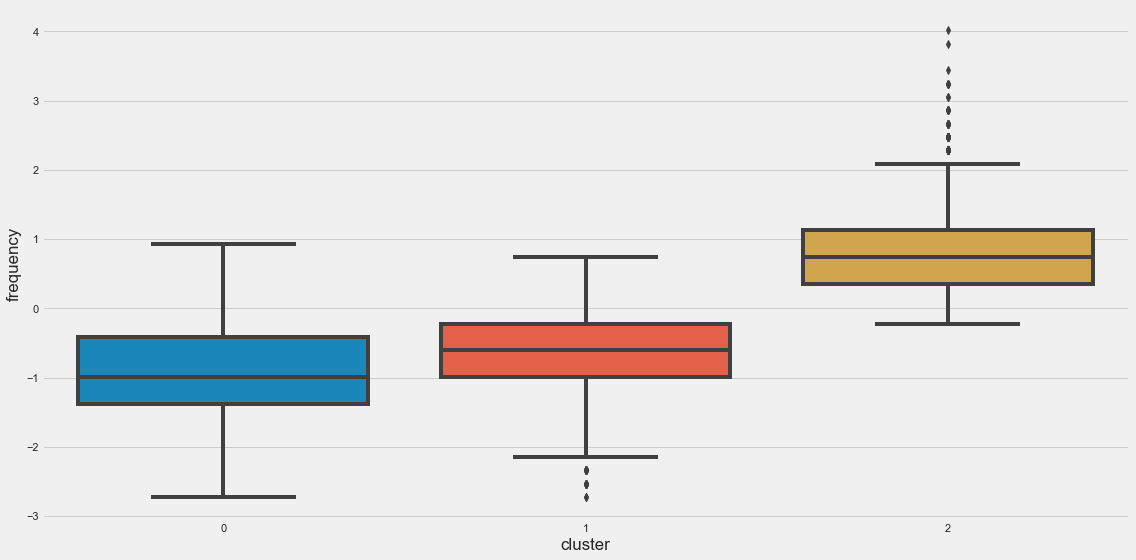

In [26]:
#see the distribution of frequency feature based on cluster
sns.boxplot(new_df.cluster,new_df.frequency)
plt.tight_layout()
plt.savefig('fig/frequency.png', tight_box=True)

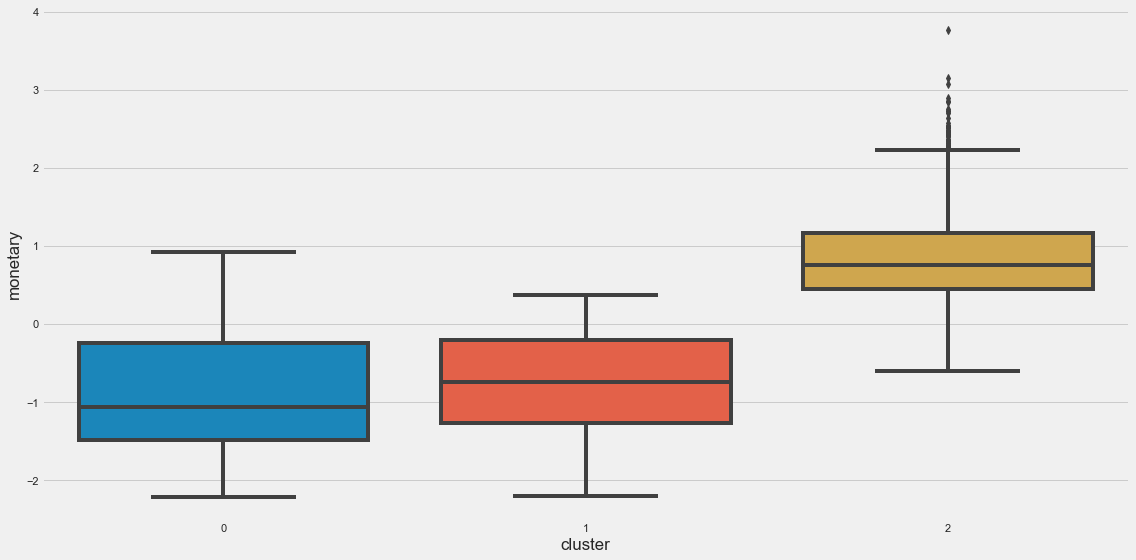

In [27]:
#see the distribution of monetary feature based on cluster
sns.boxplot(new_df.cluster,new_df.monetary)
plt.tight_layout()
plt.savefig('fig/monetary.png', tight_box=True)

**Loyal customers have low `recency` values and high `frequency` and `monetary` values, while regular customers have high `recency` values and lower `frequency` and `monetary` values.</br>
It can be seen in the `recency`,` frequency`, and `monetary` feature boxplot that the order of customers from most loyal to regular customers is cluster 2, cluster 1, and cluster 0**

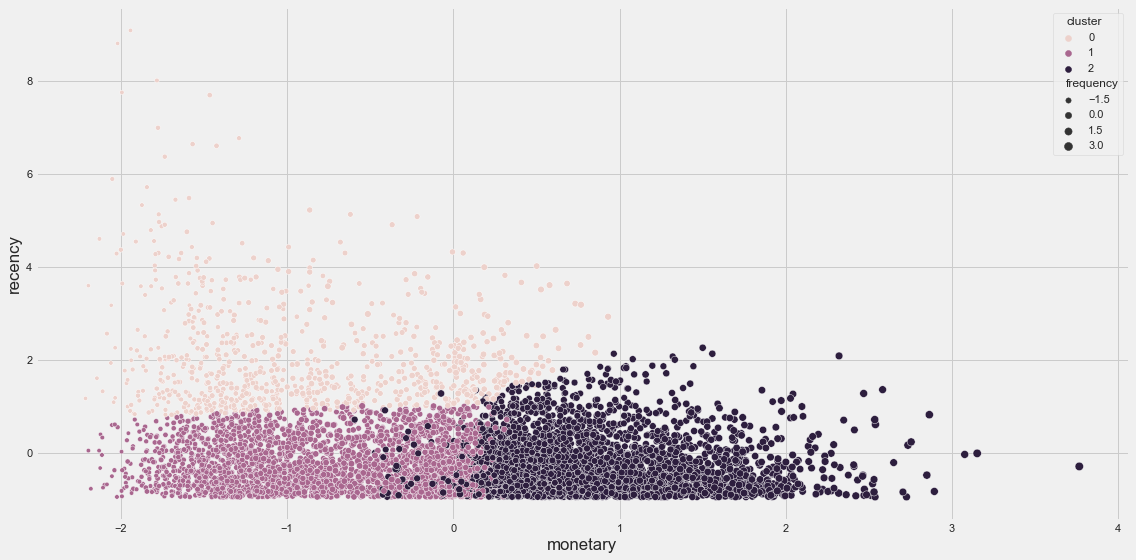

In [28]:
#see clustering distribution based on three features
sns.scatterplot(data=new_df, x='monetary', y='recency', size='frequency', 
                hue='cluster')
plt.tight_layout()
plt.savefig('fig/k-means.png', tight_box=True)

## Agglomerative Clustering

**Besides using k-means clustering, I also use aggomerative clustering to compare the customer segmentation of the two clustering models.**

In [29]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=3)
ac.fit(new_df.values)

AgglomerativeClustering(n_clusters=3)

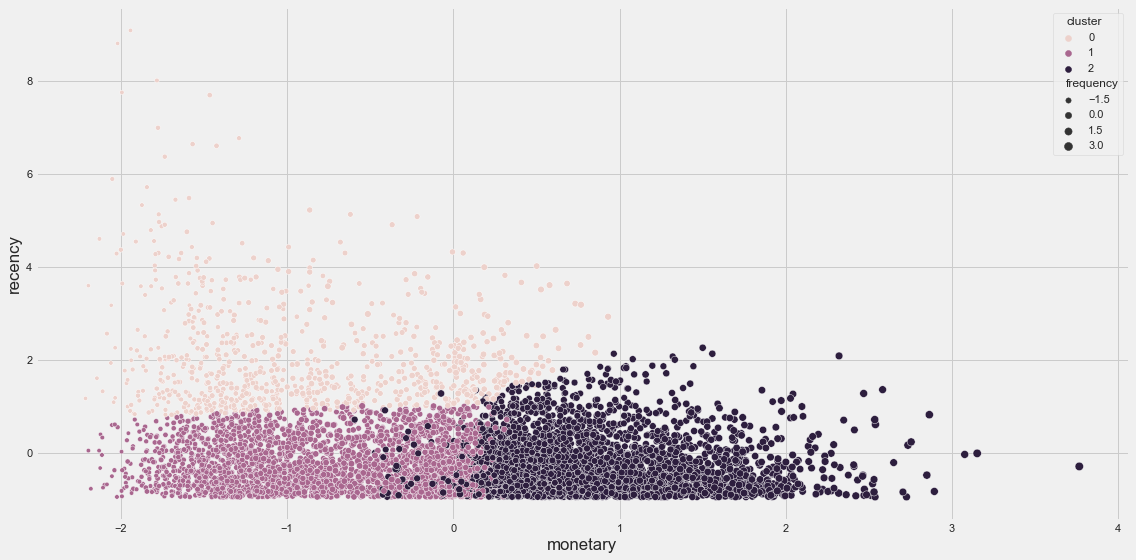

In [30]:
#see clustering distribution based on three features
sns.scatterplot(data=new_df, x='monetary', y='recency', size='frequency',
                hue='cluster')
plt.tight_layout()
plt.savefig('fig/agg.png', tight_box=True)

**There is no significant difference from the results of the two clustering models, so that customer segmentation is carried out in 3 clusters based on their RFM features.**